In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [2]:
#read CSV data and convert to Pandas Dataframe for column exctraction, then check type.
g2_data = pd.read_csv("C:/Users/maris/Documents/QC_Modeling_Bayesian/data/g2_data.csv", usecols=['photon_spacing', 'g2'])
# print(g2_data.head())
g2_array = np.array(g2_data['g2'])
time_array = np.array(g2_data['photon_spacing'])

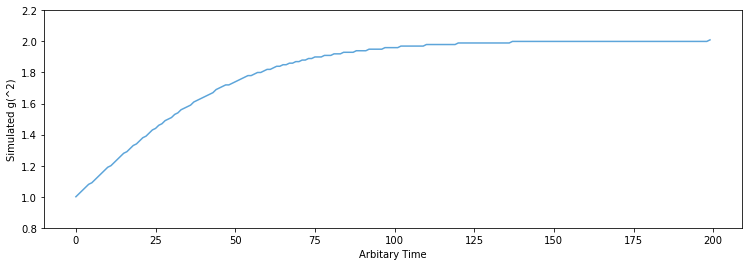

In [3]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")
#Arbitary x-label to match Andrews 20201031 MatLab axes
plt.xlabel("Arbitary Time")
plt.ylabel("Simulated g(^2)")
plt.ylim(0.8, 2.2);

In [4]:
# set random seed for reproducibility
np.random.seed(12345)
x = np.arange(1, 400, 2)

# Parameters for gaussian
amp_int = 1.0
# rho_int = 5
dampening_coeff_int = 75
offset_int = +1
oscill_int = 0

#Gaussian function based on Cortes S20 with no oscillations
#gauss = lambda x,amp,size,ps: (amp - amp*np.exp(-1*(np.pi/(3600.*200.)*size*x)**2)+ps) #Original Starting point
#For scaling and curviture (3600.*200.), np.pi, np.cos(x) + np.sin(x) (np.pi/(3600.*200.)

fit = lambda x,amp, dampening_coeff,offset: (amp - amp *((np.cos(0*x) + np.sin(0*x))*(np.exp(-x/dampening_coeff_int))) + offset)
model = fit(x=x, amp=amp_int, dampening_coeff=dampening_coeff_int, offset=offset_int)

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
model_noise = model + noise 
model__noise_error = np.ones_like(model)*0.05*model.max()
#Determine absolute error between Model and g2_from_qutip
model_error = np.abs(model - g2_array)

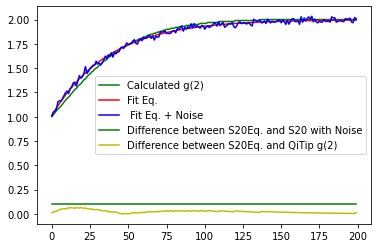

In [5]:
plt.plot(g2_array, color='g', label="Calculated g(2)")
plt.plot(model, color='r', label="Fit Eq.")
plt.plot(model_noise, color='b', label=" Fit Eq. + Noise")
plt.plot(model__noise_error, color='g', label="Difference between S20Eq. and S20 with Noise")
plt.plot(model_error, color='y', label="Difference between S20Eq. and QiTip g(2)")
plt.legend();

In [64]:
with pm.Model() as model3:
    amp = pm.Uniform('amp', 0.01, 3.5, testval = 1.0)
    dampening_coeff = pm.Normal('dampening_coeff', 50.0, 50.5, testval = 75.0)
#     oscill = pm.Uniform("oscill", -1.0, 1.0, testval = 0.0)
    offset = pm.Normal('offset', 0.13, 2, testval = 1.0)

    fit=pm.Deterministic('fit', (amp - amp *((np.cos(0*x) + np.sin(0*x))*(np.exp(-x/dampening_coeff_int))) + offset))
#   mu deterministic parameters
    y =pm.Normal('y', mu=fit, tau=1.0/model_error**2, observed=g2_array)

In [68]:
with model3:
    start=pm.find_MAP()
#     step=pm.NUTS()
    trace=pm.sample(20000)

logp = 541.1, ||grad|| = 46,696: 100%|███████████████████████████████████████████████| 17/17 [00:00<00:00, 2857.96it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, dampening_coeff, amp]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 82000/82000 [20:45<00:00, 65.86draws/s]
The acceptance probability does not match the target. It is 0.9934208682951804, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9929417227462112, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9411457697790329, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not matc

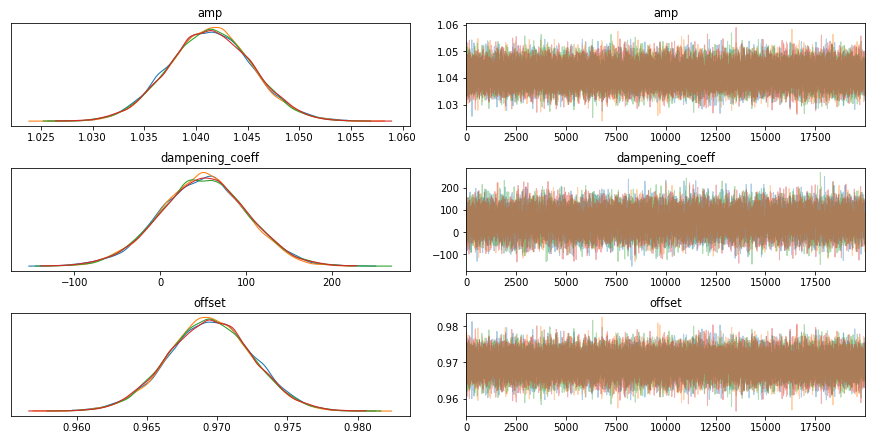

In [69]:
with model3:
    az.plot_trace(trace, var_names=["amp","dampening_coeff","offset"])

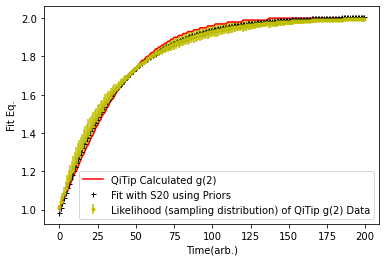

In [70]:
# extract and plot results
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.plot(time_array, g2_array,'r', label='QiTip Calculated g(2)')
# plt.plot(time_array, model_noise,'b', marker='None', ls='-', lw=1, label='S20 Model with Noise')
plt.errorbar(time_array, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of QiTip g(2) Data')
plt.plot(time_array, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit with S20 using Priors')
plt.fill_between(time_array, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");

In [71]:
#MAP Details
start

{'amp_interval__': array(-0.86872725),
 'dampening_coeff': array(74.99999959),
 'offset': array(0.96952464),
 'amp': array(1.04136202),
 'fit': array([0.98331731, 1.01035703, 1.03668521, 1.0623206 , 1.0872814 ,
        1.11158538, 1.13524982, 1.15829155, 1.18072695, 1.20257198,
        1.22384217, 1.24455266, 1.26471817, 1.28435303, 1.30347122,
        1.32208633, 1.34021159, 1.3578599 , 1.37504381, 1.39177554,
        1.40806699, 1.42392973, 1.43937507, 1.45441396, 1.46905713,
        1.48331497, 1.49719762, 1.51071496, 1.5238766 , 1.53669191,
        1.54916999, 1.56131972, 1.57314973, 1.58466845, 1.59588407,
        1.60680455, 1.61743767, 1.62779098, 1.63787186, 1.64768746,
        1.65724478, 1.6665506 , 1.67561154, 1.68443406, 1.69302441,
        1.70138872, 1.70953293, 1.71746282, 1.72518405, 1.7327021 ,
        1.74002232, 1.74714991, 1.75408995, 1.76084736, 1.76742696,
        1.77383342, 1.7800713 , 1.78614503, 1.79205894, 1.79781722,
        1.80342399, 1.80888321, 1.8141987